### notebook内で質問に答えています。 

In [36]:
import os

import numpy as np
import numpy.core.multiarray as multiarray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import shap

In [2]:
#https://www.kaggle.com/asauve/estimation-of-mulliken-charges-with-open-babel
def load_dir_csv(directory, csv_files=None):
    if csv_files is None:
        csv_files = sorted([f for f in os.listdir(directory) if f.endswith(".csv")])    
    csv_vars  = [filename[:-4] for filename in csv_files]
    gdict = globals()
    for filename, var in zip(csv_files, csv_vars):
        print(f"{var:32s} = pd.read_csv({directory}/{filename})")
        gdict[var] = pd.read_csv(f"{directory}/{filename}")
        print(f"{'nb of rows ':32s} = " + str(len(gdict[var])))
        display(gdict[var].head())

load_dir_csv("./data/")

test                             = pd.read_csv(./data//test.csv)
nb of rows                       = 4522


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,admin.,married,secondary,no,7,yes,no,cellular,27,may,224,7,105,1,other,no
1,24,admin.,married,secondary,no,61,yes,yes,cellular,7,may,278,1,343,2,other,no
2,48,blue-collar,married,primary,no,147,no,no,cellular,19,aug,158,8,-1,0,unknown,no
3,30,blue-collar,single,secondary,no,6900,no,no,cellular,21,nov,816,1,-1,0,unknown,no
4,44,technician,married,secondary,yes,-251,no,yes,telephone,31,jul,13,16,-1,0,unknown,no


train                            = pd.read_csv(./data//train.csv)
nb of rows                       = 40689


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,52,services,married,secondary,no,108,yes,no,unknown,15,may,543,12,-1,0,unknown,no
1,35,admin.,married,unknown,no,1055,no,no,cellular,2,mar,59,2,-1,0,unknown,no
2,37,blue-collar,married,secondary,no,32,yes,no,unknown,20,may,146,2,-1,0,unknown,no
3,57,unemployed,married,primary,no,2743,no,no,cellular,29,jan,89,1,-1,0,unknown,no
4,42,self-employed,married,tertiary,no,6383,no,no,cellular,27,aug,111,5,-1,0,unknown,no


In [3]:
y_train = train["y"].map({"yes":1, "no":0}).values
y_test = test["y"].map({"yes":1, "no":0}).values
train.drop("y", axis=1, inplace=True)
test.drop("y", axis=1, inplace=True)

Text(0.5, 1.0, 'train target ratio')

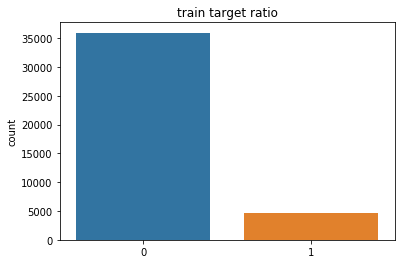

In [4]:
sns.countplot(y_train)
plt.title("train target ratio")

Text(0.5, 1.0, 'test target ratio')

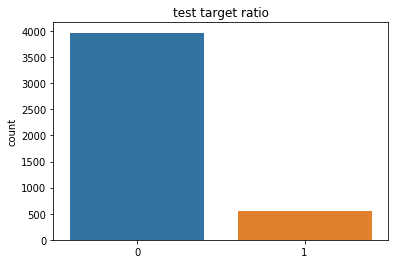

In [5]:
sns.countplot(y_test)
plt.title("test target ratio")

### Preprocessing

In [11]:
obj_cols = train.columns.values[train.dtypes == object]

X_train = pd.get_dummies(train, columns=obj_cols)
X_test = pd.get_dummies(test, columns=obj_cols)

display(X_train.head())
display(X_test.head())

cols = X_train.columns
X_train = X_train.values
X_test = X_test.values

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,52,108,15,543,12,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,35,1055,2,59,2,-1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,37,32,20,146,2,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,57,2743,29,89,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,42,6383,27,111,5,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,37,7,27,224,7,105,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,24,61,7,278,1,343,2,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,48,147,19,158,8,-1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,30,6900,21,816,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,44,-251,31,13,16,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Modeling

In [7]:
def train_model_and_show_results(model, params):
    clf = model(**params)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    tpr =  sum(y_test_pred[y_test == 1] == y_test[y_test == 1]) / len(y_test[y_test == 1])
    tnr = sum(y_test_pred[y_test == 0] == y_test[y_test == 0]) / len(y_test[y_test == 0])
    
    print(f"{clf.__class__.__name__}: train_acc was {accuracy_score(y_train, y_train_pred):.3f} and test_acc was {accuracy_score(y_test, y_test_pred):.3f}. TPR for test was {tpr:.3f} and TNR for test was {tnr:.3f}")

In [8]:
rf_params = {"n_estimators":100, "max_depth": 10, "random_state":42}
nb_params = {"priors":[len(y_train[y_train == 0]) / len(y_train), len(y_train[y_train == 1]) / len(y_train)]}

train_model_and_show_results(RandomForestClassifier, rf_params)
train_model_and_show_results(GaussianNB, nb_params)

RandomForestClassifier: train_acc was 0.907 and test_acc was 0.894. TPR for test was 0.187 and TNR for test was 0.992
GaussianNB: train_acc was 0.852 and test_acc was 0.852. TPR for test was 0.569 and TNR for test was 0.892


### 不均衡データなので全然ダメ 

In [9]:
#sample_weightを設定し、正例の重みを大きくする
weights = np.where(y_train==0, 1, len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

def train_model_and_show_results_with_weights(model, params):
    clf = model(**params)
    clf.fit(X_train, y_train, sample_weight=weights)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    tpr =  sum(y_test_pred[y_test == 1] == y_test[y_test == 1]) / len(y_test[y_test == 1])
    tnr = sum(y_test_pred[y_test == 0] == y_test[y_test == 0]) / len(y_test[y_test == 0])
    
    print(f"{clf.__class__.__name__}: train_acc was {accuracy_score(y_train, y_train_pred):.3f} and test_acc was {accuracy_score(y_test, y_test_pred):.3f}. TPR for test was {tpr:.3f} and TNR for test was {tnr:.3f}")

### rf_params = {"n_estimators":100,  "max_depth": 10, "random_state":42}
nb_params = {}

train_model_and_show_results_with_weights(RandomForestClassifier, rf_params)
train_model_and_show_results_with_weights(GaussianNB, nb_params)

### 正例の重みを大きくすることでクラス不均衡に影響を受けにくいモデルを構築できた。ナイーブベイズは直接Lossを最小化するようなアルゴリズムではないので効果が小さかったと考えられる。

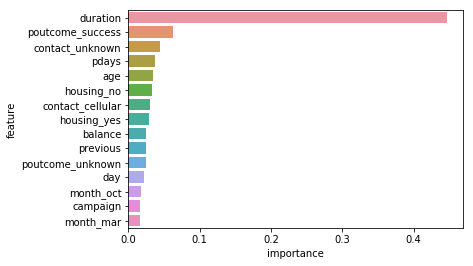

In [13]:
clf = RandomForestClassifier(**rf_params)
clf.fit(X_train, y_train, sample_weight=weights)

importances_df  = pd.DataFrame() 
importances_df["importance"]= clf.feature_importances_
importances_df["feature"] = cols
importances_df = importances_df.sort_values(by="importance", ascending=False).head(15)
sns.barplot(x="importance", y="feature", data=importances_df) 

### Durationは電話が終わったタイミングでしかわからない特徴である（成約した場合には時間が長くなるが、電話する前に利用可能な情報ではなくビジネス上意味がない） 

In [15]:
train.drop("duration", axis=1, inplace=True)
test.drop("duration", axis=1, inplace=True)

X_train = pd.get_dummies(train, columns=obj_cols)
X_test = pd.get_dummies(test, columns=obj_cols)

cols = X_train.columns
X_train = X_train.values
X_test = X_test.values

In [16]:
rf_params = {"n_estimators":100,  "max_depth": 10, "random_state":42}
nb_params = {}

train_model_and_show_results_with_weights(RandomForestClassifier, rf_params)
train_model_and_show_results_with_weights(GaussianNB, nb_params)

RandomForestClassifier: train_acc was 0.830 and test_acc was 0.822. TPR for test was 0.614 and TNR for test was 0.851
GaussianNB: train_acc was 0.796 and test_acc was 0.797. TPR for test was 0.542 and TNR for test was 0.832


### やはりduration落とすと、RFでも六割ほどしか正例は当たらない。重みをさらに大きくする 

In [17]:
weights = np.where(y_train==0, 1, 2 * len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

In [18]:
rf_params = {"n_estimators":100,  "max_depth": 10, "random_state":42}
nb_params = {}

train_model_and_show_results_with_weights(RandomForestClassifier, rf_params)
train_model_and_show_results_with_weights(GaussianNB, nb_params)

RandomForestClassifier: train_acc was 0.554 and test_acc was 0.543. TPR for test was 0.862 and TNR for test was 0.498
GaussianNB: train_acc was 0.776 and test_acc was 0.776. TPR for test was 0.569 and TNR for test was 0.805


### TPRは大きく上昇したが、かなりのFalse Positiveを生み出している。もう少し下げてみる 

In [19]:
weights = np.where(y_train==0, 1, 1.5 * len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

In [20]:
rf_params = {"n_estimators":100,  "max_depth": 10, "random_state":42}
nb_params = {}

train_model_and_show_results_with_weights(RandomForestClassifier, rf_params)
train_model_and_show_results_with_weights(GaussianNB, nb_params)

RandomForestClassifier: train_acc was 0.692 and test_acc was 0.681. TPR for test was 0.775 and TNR for test was 0.668
GaussianNB: train_acc was 0.785 and test_acc was 0.784. TPR for test was 0.556 and TNR for test was 0.816


### このくらいが妥当だろうか。この辺りは目的に応じて調整すべき。個人的には成約する可能性の高い顧客を逃したくないので多少False Positiveを出してもTPRの高いモデルが適しているのではと思う。最後にその二番目のモデルで重要度をみておく

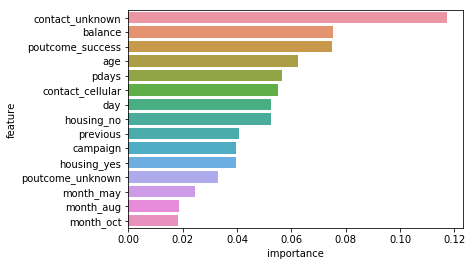

In [21]:
weights = np.where(y_train==0, 1, 2 * len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

clf = RandomForestClassifier(**rf_params)
clf.fit(X_train, y_train, sample_weight=weights)

importances_df  = pd.DataFrame() 
importances_df["importance"]= clf.feature_importances_
importances_df["feature"] = cols
importances_df = importances_df.sort_values(by="importance", ascending=False).head(15)
sns.barplot(x="importance", y="feature", data=importances_df) 

### Contact_unknownの重要度は一番大きくなっているのは解釈が難しいが、それ以外を見ると口座残高や以前のキャンペーンの成否、年齢、前回の電話からの経過日数などが上位にきており、直観に反しない。これらをもとにターゲッティングを行うことでより成約数を増やせるのではないか。